In [1]:
import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import numpy.linalg as npl
import scipy.linalg as spl
from numpy.fft import fft, ifft, fft2
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
def SMW_iteration(M, N, b, x, tol = 1.e-5, maxit = 100):
    # M, N : matrices such as A = M - N
    # M : is the first column of the circulant matrix M
    # N : is the sparse matrix N
    # x : guess of the solution
    
    err = 1.0
    iters = 0
#     cc = fft(M)
    xhist = []
    while (err > tol and iters < maxit):
        iters += 1
        c = N@x+b
#        xnew = fft(ifft(c)/cc).real
        xnew = spl.solve_circulant(M,c)
        err = npl.norm(xnew-x)
        x = np.copy(xnew)
        xhist.append(x)
        
    print('iterations required for convergence:', iters)
    
    return x, xhist

def get_spectral_radius(M:np.ndarray, N:np.ndarray):
    Minv = np.linalg.inv(M)
    G = Minv @ N
    D, V = np.linalg.eig(G)
    rho = max(abs(D))
    return rho

In [831]:
# Functions of circulant decompositions
# Minimizing frobenius norm between circulant bases
def circ_base_norm(A, omega = 1):
    n = len(A)
    Q = np.diag(np.ones(n-1), 1) + np.diag(np.ones(1), 1-n)
    d = [1/omega * np.trace(A.T @ np.linalg.matrix_power(Q,i))/n for i in range(1, n+1)]
    c = [d[(i-1) % n] for i in range(n)]
    return c

def circ_top_row(A):
    c = A[0,:]
    return c

def circ_max(A):
    n = len(A)
    Q = np.diag(np.ones(n-1), 1) + np.diag(np.ones(1), 1-n)
    d = [np.max(np.diag(A.T @ np.linalg.matrix_power(Q,i))) for i in range(1, n+1)]
    c = [d[(i-1) % n] for i in range(n)]
    return c

def circ_min(A):
    n = len(A)
    Q = np.diag(np.ones(n-1), 1) + np.diag(np.ones(1), 1-n)
    d = [np.min(np.diag(A.T @ np.linalg.matrix_power(Q,i))) for i in range(1, n+1)]
    c = [d[(i-1) % n] for i in range(n)]
    return c

def circ_max_min(A):
    n = len(A)
    Q = np.diag(np.ones(n-1), 1) + np.diag(np.ones(1), 1-n)
    d = [np.min(np.diag(A.T @ np.linalg.matrix_power(Q,i))) for i in range(1, n)]
    d.append(np.max(np.diag(A)))
    # c = [d[(i-1) % n] for i in range(n)]
    return d

0.9786409901530527


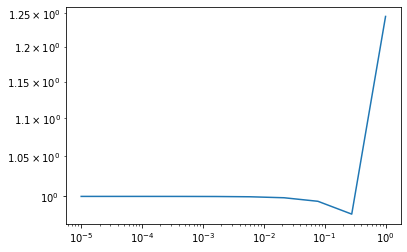

In [849]:
# Investigate SOR parameter omega on the spectral radius

n = 4
# A = np.random.randint(5, size=(n, n))
A = np.random.rand(n, n)
A = A.T @ A
# Calculate how close it is to circulant
omegas = np.logspace(-5, 0, 10)
spectral = []
for omega in omegas:
    c = circ_base_norm(A, omega)
    # print(f"Circulant Basis: {d}")

    M = sp.linalg.circulant(c).T
    N = A - M

    Minv = np.linalg.inv(M)
    G = Minv @ N
    d, v = np.linalg.eig(G)

    spectral.append(np.max(np.abs(d)))

print(np.min(spectral))
omega = np.argmin(spectral)
c = circ_base_norm(A, omegas[omega])
plt.loglog(omegas, spectral)

In [897]:
# Investigate making top row the circulant matrix

n = 4
spectral = 2
ctr = 0
while (spectral > 1) and (ctr <= 1000):
    # flag = True
    # while flag:
    #     flag=False
        # A = np.random.randint(5, size=(n, n))
    A = np.random.rand(n, n)
    # A = A.T @ A
    # Calculate how close it is to circulant
    c = circ_top_row(A)
    # c = circ_max_min(A)
    # print(f"Circulant Basis: {d}")

    M = sp.linalg.circulant(c).T
    N = A - M

    Minv = np.linalg.inv(M)
    G = Minv @ N
    d, v = np.linalg.eig(G)

    spectral = np.max(np.abs(d))
    ctr+=1

U, S, Vh = np.linalg.svd(N)
U = U @ np.diag(S)
uvt = U @ Vh
print(uvt)
print(N)

da, va = d, v = np.linalg.eig(Vh @ Minv @ U)
print(np.max(np.abs(da)))
print(np.min(spectral))
# print(c)
# print(np.argmin(spectral))
# plt.loglog(omegas, spectral)

[[ 1.67872063e-17  5.99324324e-17  4.42482027e-17 -8.14762329e-18]
 [ 3.22789313e-01 -4.25186797e-01  4.88855817e-01 -2.13565285e-01]
 [-2.34920479e-01  5.25577677e-01 -3.61481511e-01  6.60241625e-02]
 [ 1.78709065e-01  8.79873138e-02  3.81999152e-01  4.86615094e-01]]
[[ 0.          0.          0.          0.        ]
 [ 0.32278931 -0.4251868   0.48885582 -0.21356529]
 [-0.23492048  0.52557768 -0.36148151  0.06602416]
 [ 0.17870907  0.08798731  0.38199915  0.48661509]]
0.9709921896195253
0.970992189619524


[[-0.00684693 -0.65610388  0.32251349 -0.48831048]
 [ 0.65757416  0.37443592  0.52725706  0.88450637]
 [-0.23044829  0.97940236 -0.80630231  0.65864089]
 [-0.24065958 -0.54341224  0.21218454 -1.10929435]]
[-8.96960989e-01+0.19252817j -8.96960989e-01-0.19252817j
  2.45914316e-01+0.j          2.30140693e-18+0.j        ]
0.9173909255613584
[[ 8.57623961e-01 -5.81801288e-01  5.90072576e-02 -3.68527555e-01]
 [ 3.13835658e-01  1.57449230e+00  9.36462727e-02  6.13290856e-01]
 [-1.29004992e-03  7.67186158e-01  6.67331507e-01  4.30001517e-01]
 [ 2.07165474e-01 -5.30677920e-01  6.33438760e-01  4.59841952e-01]]
M Norm: 1.7909331589748183
Minv Norm: 5.7804326402699875
N Norm: 0.8974934833160939
Minv N Norm: 5.187900625389957
G Norm: 2.476080691748241
[[0.71123752 0.22691521 0.47181666 0.14798684]
 [0.14798684 0.71123752 0.22691521 0.47181666]
 [0.47181666 0.14798684 0.71123752 0.22691521]
 [0.22691521 0.47181666 0.14798684 0.71123752]]


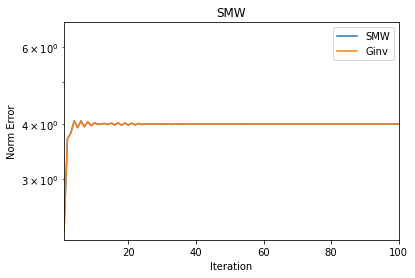

In [888]:
# Generate A
n = 4
# A = np.random.randint(5, size=(n, n))
# A = np.random.rand(n, n)
# A = A.T @ A
# Calculate how close it is to circulant
# omega = omegas[8]
# Q = np.diag(np.ones(n-1), 1) + np.diag(np.ones(1), 1-n)
# d = [1/omega * np.trace(A.T @ np.linalg.matrix_power(Q,i))/n for i in range(1, n+1)]
# c = [c[(i-1) % n] for i in range(n)]
# print(f"Circulant Basis: {d}")
M = sp.linalg.circulant(c).T
N = A - M

# Case 1
b = np.random.randint(1, 5, (4, 1))
xexact = np.linalg.solve(A, b)

# # print(b)

# initialize
err = 1.0
iters = 0
xhist = []
err = []
x = [np.zeros(shape=(4,1))]

Minv = np.linalg.inv(M)
f = Minv @ b
G = Minv @ N
print(G)
d, v = np.linalg.eig(G)
print(d)
print(np.max(np.abs(d)))

niter = 100
for i in range(niter):
    x.append(G @ x[-1] + f)

Gsum = np.zeros((4,4))
for k in range(10):
    Gsum += np.linalg.matrix_power(G, k)

print(Gsum)

x_smw = np.zeros(shape=(4,1))
# iterate
for i in range(niter):
    g = N @ x_smw + b
    xnew = spl.solve_circulant(M[:,0],g) ### This was previously M[0] which is WRONG
    xhist.append(xnew)
    err.append(npl.norm(A @ xnew - b))
    x_smw = np.copy(xnew)

print(f"M Norm: {np.linalg.norm(M)}")
print(f"Minv Norm: {np.linalg.norm(Minv)}")
print(f"N Norm: {np.linalg.norm(N)}")
print(f"Minv N Norm: {np.linalg.norm(Minv) * np.linalg.norm(N) }")
print(f"G Norm: {np.linalg.norm(G)}")
# print(f"Minv bound: {np.linalg.norm(M - np.eye(n))}")

# # plot
plt.semilogy(range(1,len(xhist)+1), err, label="SMW")
plt.xlabel("Iteration")
plt.ylabel("Norm Error")
plt.xlim(1, len(xhist))
plt.title("SMW")

plt.semilogy([np.linalg.norm(A @ i - b) for i in x], label="Ginv")
plt.legend()
# plt.plot(x)
print(M)

In [460]:
# print(A)
# print(M)
# print(N)
print(G)
Gsum = np.zeros((4,4))
for k in range(10):
    Gsum += np.linalg.matrix_power(G, k)

print(Gsum)

[[-1.22643223 -0.78377936 -0.86670987 -1.24847663]
 [ 0.21946213  0.32950893 -0.15556388  0.05529659]
 [ 0.63192762  0.36654936  0.5246678   0.97612492]
 [-0.03678168  0.17948566  0.66246514  0.37225551]]
[[-0.85891712 -2.0250351  -3.16593294 -3.80838097]
 [-0.22470559  0.76725852 -1.46509117 -1.39830489]
 [ 1.43220277  1.71301658  4.14164274  3.83429567]
 [ 0.99304674  1.79066599  3.65728612  4.79875883]]


[[-0.3   0.    0.   -0.3 ]
 [-0.05  0.    0.   -0.05]
 [ 0.2   0.    0.    0.2 ]
 [-0.05  0.    0.   -0.05]]
[ 0.    0.   -0.35  0.  ]
0.35000000000000003
M Norm: 10.954451150103322
Minv Norm: 0.714142842854285
N Norm: 2.0
Minv N Norm: 1.42828568570857
G Norm: 0.5196152422706632


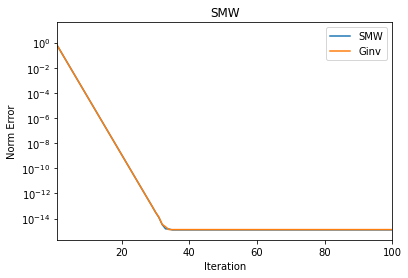

In [504]:
# Generate A
A =  np.array([[5.,3.,2.,2.],
               [1.,4.,3.,2.],
               [2.,1.,4.,3.],
               [4.,2.,1.,5.]])

N = sps.lil_matrix((4, 4))
N[0,0]=-1.0; N[3,0]=-1.0; N[0,3]=-1.0; N[3,3]=-1.0
N = N.toarray()
M = A + N

# Case 1
b = np.random.randint(1, 5, (4, 1))
xexact = np.linalg.solve(A, b)

# # print(b)

# initialize
err = 1.0
iters = 0
xhist = []
err = []
x = [np.zeros(shape=(4,1))]

Minv = np.linalg.inv(M)
f = Minv @ b
G = Minv @ N
print(G)
d, v = np.linalg.eig(G)
print(d)
print(np.max(np.abs(d)))

niter = 100
for i in range(niter):
    x.append(G @ x[-1] + f)

x_smw = np.zeros(shape=(4,1))
# iterate
for i in range(niter):
    c = N @ x_smw + b
    xnew = spl.solve_circulant(M[:,0],c) ### This was previously M[0] which is WRONG
    xhist.append(xnew)
    err.append(npl.norm(A @ xnew - b))
    x_smw = np.copy(xnew)

print(f"M Norm: {np.linalg.norm(M)}")
print(f"Minv Norm: {np.linalg.norm(Minv)}")
print(f"N Norm: {np.linalg.norm(N)}")
print(f"Minv N Norm: {np.linalg.norm(Minv) * np.linalg.norm(N) }")
print(f"G Norm: {np.linalg.norm(G)}")
# print(f"Minv bound: {np.linalg.norm(M - np.eye(n))}")

# # plot
plt.semilogy(range(1,len(xhist)+1), err, label="SMW")
plt.xlabel("Iteration")
plt.ylabel("Norm Error")
plt.xlim(1, len(xhist))
plt.title("SMW")

plt.semilogy([np.linalg.norm(A @ i - b) for i in x], label="Ginv")
plt.legend()
# plt.plot(x)

[[-0.94640913  0.          0.         -0.94640913]
 [-0.95696532  0.          0.         -0.95696532]
 [ 0.52381571  0.          0.          0.52381571]
 [ 0.5343719   0.          0.          0.5343719 ]]
[ 0.          0.         -0.41203724  0.        ]
0.41203723667649217
M Norm: 2.7308068948194935
Minv Norm: 2.3710085894018462
N Norm: 2.0
Minv N Norm: 4.7420171788036924
G Norm: 2.17780122971385


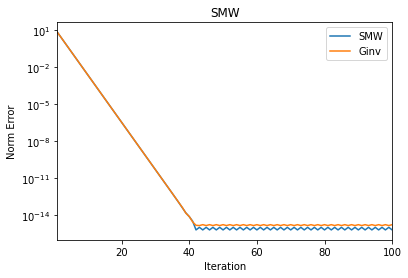

In [862]:
# Generate A
# A =  np.array([[5.,3.,2.,2.],
#                [1.,4.,3.,2.],
#                [2.,1.,4.,3.],
#                [4.,2.,1.,5.]])

M = sp.linalg.circulant(np.random.rand(4))

N = sps.lil_matrix((4, 4))
N[0,0]=-1.0; N[3,0]=-1.0; N[0,3]=-1.0; N[3,3]=-1.0
N = N.toarray()

A = M - N


# Case 1
b = np.random.randint(1, 5, (4, 1))
xexact = np.linalg.solve(A, b)

# # print(b)

# initialize
err = 1.0
iters = 0
xhist = []
err = []
x = [np.zeros(shape=(4,1))]

Minv = np.linalg.inv(M)
f = Minv @ b
G = Minv @ N
print(G)
d, v = np.linalg.eig(G)
print(d)
print(np.max(np.abs(d)))

niter = 100
for i in range(niter):
    x.append(G @ x[-1] + f)


x_smw = np.zeros(shape=(4,1))
# iterate
for i in range(niter):
    c = N @ x_smw + b
    xnew = spl.solve_circulant(M[:,0],c) ### This was previously M[0] which is WRONG
    xhist.append(xnew)
    err.append(npl.norm(A @ xnew - b))
    x_smw = np.copy(xnew)

print(f"M Norm: {np.linalg.norm(M)}")
print(f"Minv Norm: {np.linalg.norm(Minv)}")
print(f"N Norm: {np.linalg.norm(N)}")
print(f"Minv N Norm: {np.linalg.norm(Minv) * np.linalg.norm(N) }")
print(f"G Norm: {np.linalg.norm(G)}")
# print(f"Minv bound: {np.linalg.norm(M - np.eye(n))}")

# # plot
plt.semilogy(range(1,len(xhist)+1), err, label="SMW")
plt.xlabel("Iteration")
plt.ylabel("Norm Error")
plt.xlim(1, len(xhist))
plt.title("SMW")

plt.semilogy([np.linalg.norm(A @ i - b) for i in x], label="Ginv")
plt.legend()
# plt.plot(x)